# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
%matplotlib notebook

### Rozwiązanie

## Zapisywanie punktów do pliku i wczytywanie ich

Aby zapisać wykres do pliku należy skorzystać z funkcji writeToFile(), która w argumentach przyjmuje nazwę pliku i obiekt klasy Plot. Nazwa pliku powinna mieć rozszerzenie .json.

In [3]:
def writeToFile(fileName: str, pointset: Plot) -> None:
    with open(fileName, 'w') as f:
        f.write(pointset.toJson())
    f.close()


Aby wykres z pliku należy skorzystać z funkcji readFromFile(), która w argumencie przyjmuje nazwę pliku, a zwraca obiekt klasy Plot. Nazwa pliku powinna mieć rozszerzenie .json.

In [4]:
def readFromFile(fileName: str) -> Plot:
    with open(fileName, 'r') as f:
        json = f.read()
    f.close()
    return Plot(json=json)


Funkcja emptyCanvas tworzy obszar na którym można zadać odcinki do sprawdzenia algorytmu przy pomocy narzędzia wizualizującego. W parametrach można podać szerokość i wysokość obszaru.

<IPython.core.display.Javascript object>


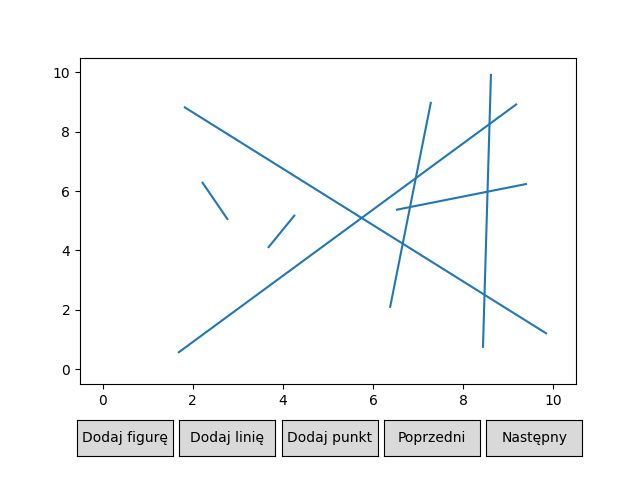

In [5]:
def emptyCanvas(xLim: int=10, yLim: int=10) -> Plot:
    return Plot(points=[PointsCollection([(xLim, yLim), (0, 0)], color='white')])
newDrawing = emptyCanvas()
newDrawing.draw()

Po narysowaniu odcinków te mogą zostać zapisane do pliku json.

In [6]:
writeToFile("sampleLines.json", Plot(scenes=[newDrawing.get_added_elements()]))


Aby uzyskać informację o narysowanych odcinkach można użyć funkcji getSegmentsFromScene() - w przypadku, gdy odcinki zostały wczytane z zewnętrznego pliku do zmiennej, albo getSegmentsAddedToPlot(), gdy chcemy otrzymać odcinki narysowane na wykresie. Funkcje zwracają listę par dwóch współrzędnych oznaczających punkty krańce odcinków.

In [7]:
def getSegmentsFromScene(p: Plot) -> list:
    return p.scenes[0].lines[0].lines

# p = readFromFile("sampleLines.json")
# p.draw()
# edges = getSegmentsFromScene(p)
# # print(edges)

def getSegmentsAddedToPlot(polygon: Plot) -> list:
    return polygon.get_added_lines()[0].lines

# edges2 = getSegmentsAddedToPlot(newDrawing)
# # print(edges2)


## Generowanie losowych odcinków

Poniższa funkcja odpowiada za wylosowanie wybranej liczby odcinków na zadanym przedziale

In [8]:
import random
def genSegments(n, xMin, xMax, yMin, yMax, maxLen = None):
    if maxLen != None: maxLen = maxLen**2
    xPoints = set()
    segments = []
    i = 0
    while i < n:
        x1 = random.uniform(xMin, xMax)
        x2 = random.uniform(xMin, xMax)
        if x1 in xPoints or x2 in xPoints: continue
        y1 = random.uniform(yMin, yMax)
        y2 = random.uniform(yMin, yMax)
        if x1 == x2: continue
        if maxLen != None and ((x1-x2)**2 + (y1-y2)**2) > maxLen: continue
        segments.append([[x1, y1], [x2, y2]])
        xPoints.add(x1)
        xPoints.add(x2)
        i += 1
    return segments
        

In [9]:
testSegments = genSegments(5, 0, 10, 0, 10)

Wygenerowane punkty można zwizualizować na wykresie przy pomocy poniższej funkcji

In [10]:
def genSegmentsPlot(segments, points = None):
    a = LinesCollection(segments)
    if points != None:
        b = PointsCollection(points, color='violet')
        return Plot(points=[b], lines=[a])
    return Plot(lines=[a])


Wygenerowane punkty można teraz wyświetlić, oraz je wypisać.

C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


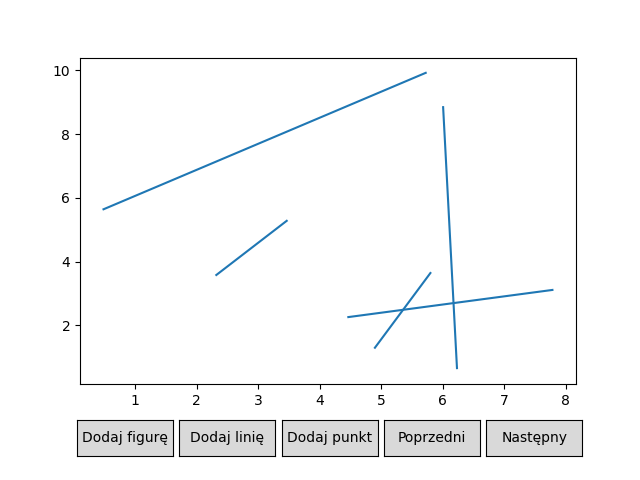

In [11]:
drawing = genSegmentsPlot(testSegments)
drawing.draw()


# Reprezentacja punktu i odcinka

In [12]:
from sortedcontainers import SortedSet
START = 0
END = 1
CROSS = 2

class Point():
    def __init__(self, coords) -> None:
        self.x = coords[0]
        self.y = coords[1]
        self.edgIdx = None
        self.type = None
        self.crsIdxs = (None, None)
        
    def getIter(self):
        return (self.x, self.y)
    
    def __str__(self):
        return str(self.getIter())
    
    def __repr__(self):
        return self.__str__()
    
class Segment():
    def __init__(self, seg):
        p1 = seg[0]
        p2 = seg[1]

        if p1.x < p2.x:
            self.start = p1
            self.end = p2
        else:
            self.start = p2
            self.end = p1

        self.start.type = START
        self.end.type = END
        self.a = (self.end.y - self.start.y) / (self.end.x - self.start.x)
        self.b = (self.end.y - self.a * self.end.x)
        self.sortValue = self.start.y
        self.idx = None
        
    def setIdx(self, idx):
        self.start.edgIdx = idx
        self.end.edgIdx = idx
        self.idx = idx
    
    def inBoundries(self, p):
        if p.x > self.end.x or p.x < self.start.x: return False
        if p.y > max(self.start.y, self.end.y) or p.y < min(self.start.y, self.end.y): return False
        return True
    
    def getValY(self, x):
        return self.a * x + self.b
    
    def intersection(self, seg):
        if self.a == seg.a: return None
        x = (seg.b - self.b) / (self.a - seg.a)
        y = self.a * x + self.b
        p = Point((x, y))
        p.crsIdxs = (min(seg.idx, self.idx), max(seg.idx, self.idx))
        p.type = CROSS
        if self.inBoundries(p) and seg.inBoundries(p): return p
        return None
    
    
    def getIter(self):
        return [self.start.getIter(), self.end.getIter()]
        
    def __str__(self):
        return str([self.start, self.end])
    
    def __repr__(self):
        return self.__str__()
        
                    

## Reprezentacja zbioru prostych, struktury zdarzeń i miotły oraz implementacja algorytmów

In [13]:
class SegmentCloud():
    def __init__(self, segments):
        self.segments = []
        self.points = []
        self.out = None
        self.minY = float("inf")
        self.maxY = -float("inf")
        for i, segment in enumerate(segments):
            p1 = Point(segment[0])
            p2 = Point(segment[1])
            seg = Segment((p1, p2))
            self.segments.append(seg)
            self.points.append(p1)
            self.points.append(p2)
            self.segments[i].setIdx(i)
            self.maxY = max(self.maxY, p1.y, p2.y)
            self.minY = min(self.minY, p1.y, p2.y)
    
    def findIntersectionsBasic(self):
        intersections = []
        intersectionsIdx = set()
        for s1 in self.segments:
            for s2 in self.segments:
                if s1 == s2: continue
                p = s1.intersection(s2)
                if p != None and p.crsIdxs not in intersectionsIdx:
                    intersections.append(p)
                    intersectionsIdx.add(p.crsIdxs)
        print(len(intersections))
        scene = []
        scene.append(Scene(points=[self.getPC(intersections, "red")],
                           lines=[self.getLC(self.segments)]))
        return scene
    
    def hasIntersections(self):
        sweep = SortedSet(key=lambda x : (x.sortValue, x.a))
        event = SortedSet(self.points, key=lambda p:p.x)
        
        while len(event) > 0:
            currEvent = event.pop(0)
            if currEvent.type == START:
                self.updateSweep(sweep, currEvent.x)
                toInsert = self.segments[currEvent.edgIdx]
                sweep.add(toInsert)
                i = sweep.index(toInsert)
                if i > 0:
                    p = sweep[i].intersection(sweep[i-1])
                    if p != None: return True
                if i < len(sweep) - 1:
                    p = sweep[i].intersection(sweep[i+1])
                    if p != None: return True
                        
            if currEvent.type == END:
                self.updateSweep(sweep, currEvent.x)
                toRemove = self.segments[currEvent.edgIdx]
                i = sweep.index(toRemove)
                if i > 0 and i < len(sweep) - 1:
                    p = sweep[i-1].intersection(sweep[i+1])
                    if p != None: return True
                sweep.remove(toRemove)
        return False


    def hasIntersectionsAnimation(self):
        sweep = SortedSet(key=lambda x : (x.sortValue, x.a))
        event = SortedSet(self.points, key=lambda p:p.x)
        scenes = []
        processedLines = []
        processedPoints = []
        scenes.append(Scene(lines=[self.getLC(self.segments)],
                            points=[self.getPC(self.points)]))
        
        while len(event) > 0:
            currEvent = event.pop(0)
            scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC([currEvent], "lime"),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC(list(event))]))
            if currEvent.type == START:
                self.updateSweep(sweep, currEvent.x)
                toInsert = self.segments[currEvent.edgIdx]
                sweep.add(toInsert)
                i = sweep.index(toInsert)
                if i > 0:
                    p = sweep[i].intersection(sweep[i-1])
                    if p != None:
                        scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC([currEvent], "lime"),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC(list(event)),
                                        self.getPC([p], "red")]))
                        return scenes
                if i < len(sweep) - 1:
                    p = sweep[i].intersection(sweep[i+1])
                    if p != None:
                        scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC([currEvent], "lime"),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC(list(event)),
                                        self.getPC([p], "red")]))
                        return scenes
                        
            if currEvent.type == END:
                self.updateSweep(sweep, currEvent.x)
                toRemove = self.segments[currEvent.edgIdx]
                i = sweep.index(toRemove)
                if i > 0 and i < len(sweep) - 1:
                    p = sweep[i-1].intersection(sweep[i+1])
                    if p != None:
                        scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC([currEvent], "lime"),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC(list(event)),
                                        self.getPC([p], "red")]))
                        return scenes
                processedLines.append(toRemove)
                sweep.remove(toRemove)
            processedPoints.append(currEvent)
        return scenes

    def intersections(self):
        intersectIdxs = set()
        intersectPts = []
        sweep = SortedSet(key=lambda x : (x.sortValue, x.a))
        event = SortedSet(self.points, key=lambda p:p.x)
        
        while len(event) > 0:
            currEvent = event.pop(0)
            if currEvent.type == START:
                self.updateSweep(sweep, currEvent.x)
                toInsert = self.segments[currEvent.edgIdx]
                sweep.add(toInsert)
                i = sweep.index(toInsert)
                if i > 0:
                    p = sweep[i].intersection(sweep[i-1])
                    if p != None and p.crsIdxs not in intersectIdxs:
                        intersectIdxs.add(p.crsIdxs)
                        intersectPts.append(p)
                        event.add(p)
                if i < len(sweep) - 1:
                    p = sweep[i].intersection(sweep[i+1])
                    if p != None and p.crsIdxs not in intersectIdxs:
                        intersectIdxs.add(p.crsIdxs)
                        intersectPts.append(p)
                        event.add(p)
                        
            if currEvent.type == END:
                self.updateSweep(sweep, currEvent.x)
                toRemove = self.segments[currEvent.edgIdx]
                i = sweep.index(toRemove)
                if i > 0 and i < len(sweep) - 1:
                    p = sweep[i-1].intersection(sweep[i+1])
                    if p != None and p.crsIdxs not in intersectIdxs:
                        intersectIdxs.add(p.crsIdxs)
                        intersectPts.append(p)
                        event.add(p)
                sweep.remove(toRemove)
            
            if currEvent.type == CROSS:
                self.updateSweep(sweep, currEvent.x)
                i, j = currEvent.crsIdxs
                s1 = self.segments[i]
                s2 = self.segments[j]
                sweep.remove(s1)
                sweep.remove(s2)
                s2.sortValue = s1.sortValue
                sweep.add(s1)
                sweep.add(s2)
                if s1.a < s2.a:
                    i = sweep.index(s1)
                    j = sweep.index(s2)
                else:
                    i = sweep.index(s2)
                    j = sweep.index(s1)
                if i > 0:
                    p = sweep[i].intersection(sweep[i-1])
                    if p != None and p.crsIdxs not in intersectIdxs:
                        intersectIdxs.add(p.crsIdxs)
                        intersectPts.append(p)
                        event.add(p)
                if j < len(sweep) - 1:
                    p = sweep[j].intersection(sweep[j+1])
                    if p != None and p.crsIdxs not in intersectIdxs:
                        intersectIdxs.add(p.crsIdxs)
                        intersectPts.append(p)
                        event.add(p)
        
        scenes = []
        scenes.append(Scene(points=[self.getPC(intersectPts, "red")],
                           lines=[self.getLC(self.segments)]))
        out = []
        for el in intersectPts:
            out.append((el, self.segments[el.crsIdxs[0]], self.segments[el.crsIdxs[1]]))
        self.out = []
        self.out = [len(intersectPts), out]
        return scenes, len(intersectPts), out
    
    
    def intersectionsAnimation(self):
        scenes = []
        intersectIdxs = set()
        intersectPts = []
        processedLines = []
        processedPoints = []
        sweep = SortedSet(key=lambda x : (x.sortValue, x.a))
        event = SortedSet(self.points, key=lambda p:p.x)
        scenes.append(Scene(lines=[self.getLC(self.segments)],
                            points=[self.getPC(self.points)]))
        
        
        while len(event) > 0:
            currEvent = event.pop(0)
            scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC([currEvent], "lime"),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC(list(event)),
                                        self.getPC(intersectPts, "red")]))
            
            if currEvent.type == START:
                self.updateSweep(sweep, currEvent.x)
                toInsert = self.segments[currEvent.edgIdx]
                sweep.add(toInsert)
                scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC(list(event)),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC([currEvent], "lime"),
                                        self.getPC(intersectPts, "red")]))
                i = sweep.index(toInsert)
                if i > 0:
                    p = sweep[i].intersection(sweep[i-1])
                    if p != None and p.crsIdxs not in intersectIdxs:
                        intersectIdxs.add(p.crsIdxs)
                        intersectPts.append(p)
                        event.add(p)
                        scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC(list(event)),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC([currEvent], "lime"),
                                        self.getPC(intersectPts, "red")]))
                if i < len(sweep) - 1:
                    p = sweep[i].intersection(sweep[i+1])
                    if p != None and p.crsIdxs not in intersectIdxs:
                        intersectIdxs.add(p.crsIdxs)
                        intersectPts.append(p)
                        event.add(p)
                        scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC(list(event)),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC([currEvent], "lime"),
                                        self.getPC(intersectPts, "red")]))
                        
            if currEvent.type == END:
                self.updateSweep(sweep, currEvent.x)
                toRemove = self.segments[currEvent.edgIdx]
                i = sweep.index(toRemove)
                if i > 0 and i < len(sweep) - 1:
                    p = sweep[i-1].intersection(sweep[i+1])
                    if p != None and p.crsIdxs not in intersectIdxs:
                        intersectIdxs.add(p.crsIdxs)
                        intersectPts.append(p)
                        event.add(p)
                        scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC(list(event)),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC([currEvent], "lime"),
                                        self.getPC(intersectPts, "red")]))
                processedLines.append(toRemove)
                sweep.remove(toRemove)
            
            if currEvent.type == CROSS:
                self.updateSweep(sweep, currEvent.x)
                i, j = currEvent.crsIdxs
                s1 = self.segments[i]
                s2 = self.segments[j]
                sweep.remove(s1)
                sweep.remove(s2)
                s2.sortValue = s1.sortValue
                sweep.add(s1)
                sweep.add(s2)
                if s1.a < s2.a:
                    i = sweep.index(s1)
                    j = sweep.index(s2)
                else:
                    i = sweep.index(s2)
                    j = sweep.index(s1)
                if i > 0:
                    p = sweep[i].intersection(sweep[i-1])
                    if p != None and p.crsIdxs not in intersectIdxs:
                        intersectIdxs.add(p.crsIdxs)
                        intersectPts.append(p)
                        event.add(p)
                        scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC(list(event)),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC([currEvent], "lime"),
                                        self.getPC(intersectPts, "red")]))
                if j < len(sweep) - 1:
                    p = sweep[j].intersection(sweep[j+1])
                    if p != None and p.crsIdxs not in intersectIdxs:
                        intersectIdxs.add(p.crsIdxs)
                        intersectPts.append(p)
                        event.add(p)
                        scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(currEvent.x)],
                                points=[self.getPC(list(event)),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC([currEvent], "lime"),
                                        self.getPC(intersectPts, "red")]))
            processedPoints.append(currEvent)
        scenes.append(Scene(lines=[self.getLC(self.segments)],
                            points=[self.getPC(self.points),
                                    self.getPC(intersectPts, "red")]))
        out = []
        for el in intersectPts:
            out.append((el, self.segments[el.crsIdxs[0]], self.segments[el.crsIdxs[1]]))
        self.out = []
        self.out = [len(intersectPts), out]
        return scenes
                
    def savePointsToFile(self, filename):
        with open(filename, "w") as f:
            f.write(str(self.out))
        f.close()
        
    def updateSweep(self, sweep, x):
        tmp = SortedSet(key=lambda x : (x.sortValue, x.a))
        for el in sweep:
            el.sortValue = el.getValY(x)
            tmp.add(el)
        sweep.update(tmp)
    
    def getLC(self, segmentSet, col="navy"):
        out = []
        for el in segmentSet:
            out.append(el.getIter())
        return LinesCollection(out, color=col)
    
    def getPC(self, pointsSet, col="navy"):
        out = []
        for el in pointsSet:
            out.append(el.getIter())
        return PointsCollection(out, color=col)
    
    def getSweep(self, xCoord, col="red"):
        # d = abs(self.minY - self.maxY) * 0.05
        d=0
        return LinesCollection([[[xCoord, self.minY - d], [xCoord, self.maxY + d]]], color=col)
    


## Przykładowe użycia programu

Poniżej można narysować układ linii, który zostanie sprawdzony pod kątem istnienia przecięć. Jeszcze niższe komórki wyświetlą, czy istnieje przecięcie, a także animację działania algorytmu zamiatania.

C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


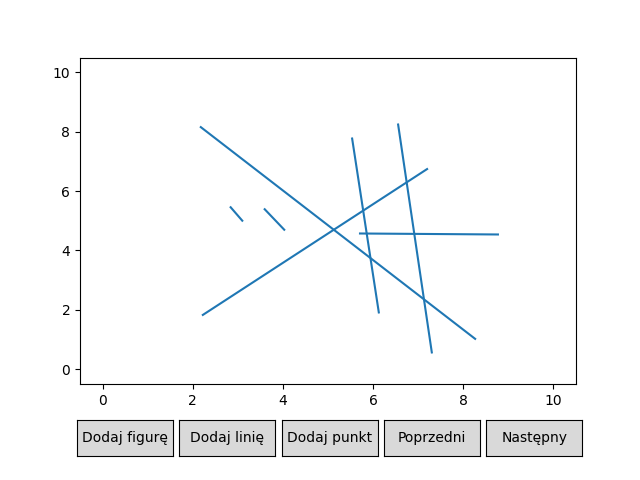

In [14]:
d = emptyCanvas()
d.draw()

True


C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


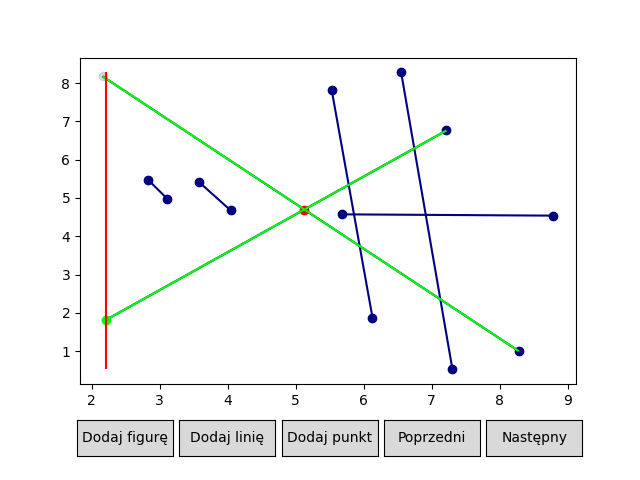

In [15]:
d = SegmentCloud(getSegmentsAddedToPlot(d))
print(d.hasIntersections())
p = Plot(scenes=d.hasIntersectionsAnimation())
p.draw()

Poniżej można narysować układ linii, na którym zostanie zastosowany algorytm wykrywania przecięć. Jeszcze niższa komórka wyświetli animację działania algorytmu.

C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


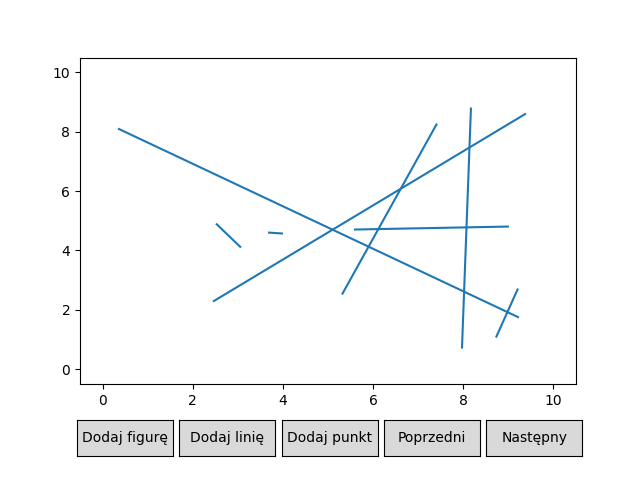

In [18]:
d = emptyCanvas()
d.draw()


C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


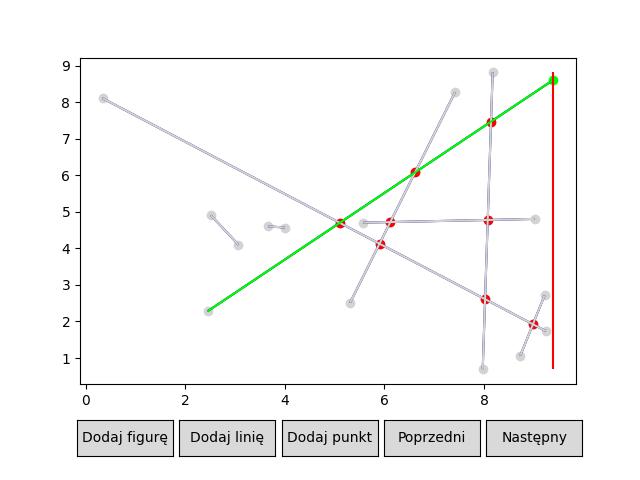

In [19]:
sc = SegmentCloud(getSegmentsAddedToPlot(d))
p = Plot(scenes=sc.intersectionsAnimation())
p.draw()


Jeżeli chcemy, możemy wypisać punkty przecięć i informację o ich ilości, albo zapisać te dane do pliku.

In [20]:
# print(sc.intersections()[1:])
sc.intersections()
sc.savePointsToFile("save.json")


In [21]:
writeToFile("test.json", Plot(scenes=[d.get_added_elements()])) # zapisanie narysowanego wykresu

Aby wczytać wykres należy mieć go zapisanego w pliku .json w formacie interpretowanym przez użyte narzędzie graficzne (czyli na przykład taki plik mógł zostać wygenerowany funkcją writeToFile() przyjmującą wykres)

C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


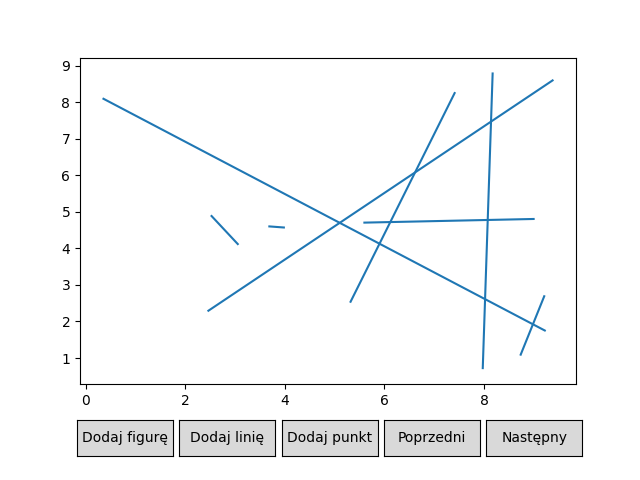

In [22]:
w1 = readFromFile("test.json")
w1.draw()

Na wczytanym pliku można uruchomić algorytm sprawdzający, czy istnieją przecięcia

C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


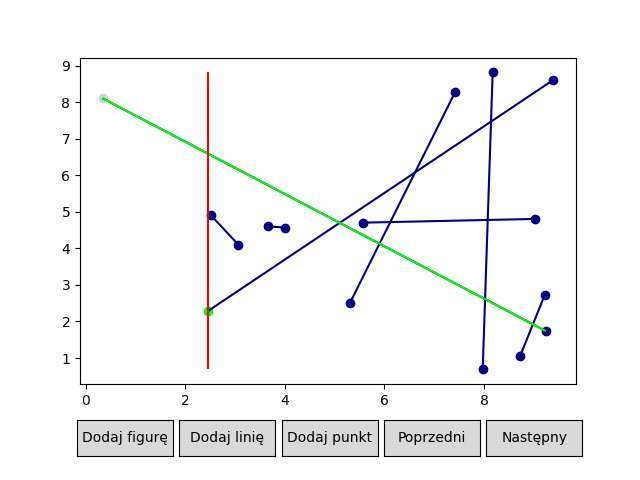

In [23]:
sc2 = SegmentCloud(getSegmentsFromScene(w1))
dr2 = Plot(scenes=sc2.hasIntersectionsAnimation())
dr2.draw()

Jak i algorytm znajdujący wszystkie przecięcia

C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


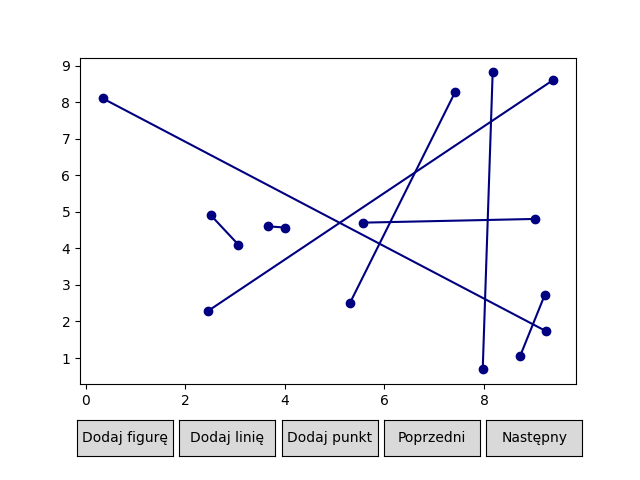

In [24]:
sc2 = SegmentCloud(getSegmentsFromScene(w1))
dr2 = Plot(scenes=sc2.intersectionsAnimation())
dr2.draw()

Jeżeli chcemy wygenerować odcinki należy postąpić jak w kodzie poniżej

C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


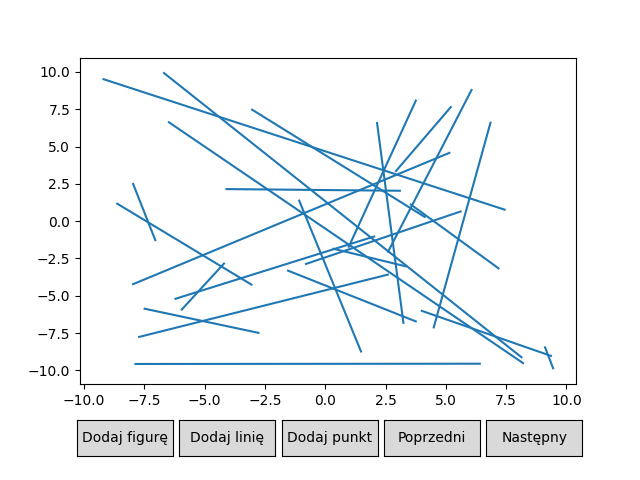

In [33]:
dr = genSegmentsPlot(genSegments(25, -10, 10, -10, 10))
dr.draw()

C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


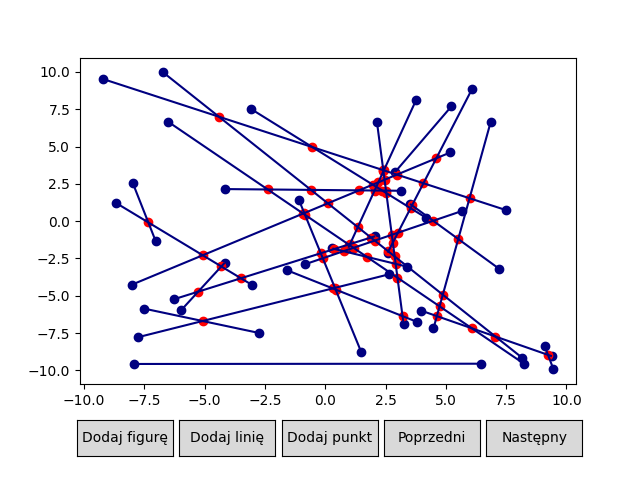

In [34]:
pc = SegmentCloud(getSegmentsFromScene(dr))
p = Plot(scenes=pc.intersectionsAnimation())
p.draw()

C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


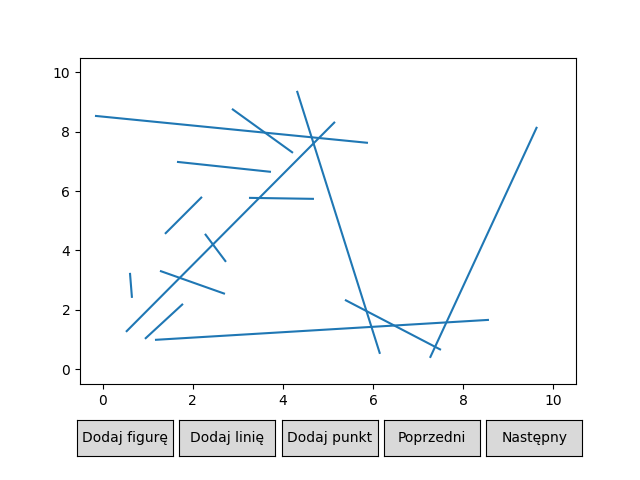

In [44]:
d = emptyCanvas()
d.draw()


C:\Users\Domin\AppData\Local\Temp\ipykernel_13980\1732447589.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


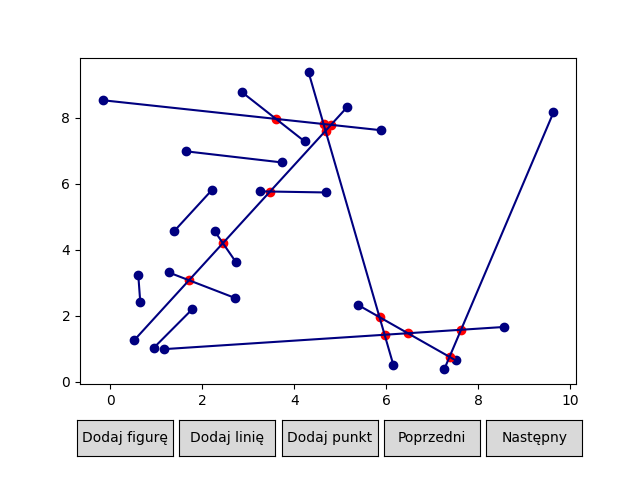

In [45]:
sc = SegmentCloud(getSegmentsAddedToPlot(d))
p = Plot(scenes=sc.intersectionsAnimation())
p.draw()


In [ ]:
v